In [1]:
import os
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import *
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# to make this notebook's output stable across runs
np.random.seed(666)

In [2]:
_data = pd.read_csv(r'D:\文档\kaggle\coding\数据科学-datawhale\data.csv',engine='python') #4754*90
data = _data.copy()

In [3]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [4]:
#第一列没有列名,且为index项,删除
data.drop([data.columns[0]], axis=1, inplace=True)


In [5]:
#统计每列的缺失值个数, 并对其进行降序排列
data.isnull().sum().sort_values(ascending=False)

student_feature                               2998
cross_consume_count_last_1_month               426
query_org_count                                304
query_cash_count                               304
latest_six_month_apply                         304
latest_three_month_apply                       304
latest_query_time                              304
query_sum_count                                304
latest_one_month_apply                         304
query_finance_count                            304
apply_credibility                              304
apply_score                                    304
latest_query_day                               304
latest_one_month_loan                          297
loans_score                                    297
loans_credibility_behavior                     297
loans_count                                    297
loans_settle_count                             297
loans_overdue_count                            297
loans_org_count_behavior       

In [6]:
#'student_feature' 这列考虑删除, 或者将NA以0填充
data[['student_feature', 'status']].groupby(data['status']).count()

,student_feature,status
status,,
0,1307,3561
1,449,1193


In [7]:
#根据上面显示student_feature,应该与status是非常弱相关.所以删除,corr可以查看
data.drop(['student_feature'], axis=1, inplace=True)
#数据NA具有同一数据性,比如上面有大量297 304NA数据,他们也通常出自于相同也数据,也就是
#大量304NA数据出自于304个数据

In [8]:
#先自主浏览一下csv文件 肉眼识别需要删除文件
#1.查找所有dtype为object的列, 看是否需要删除
for i in range(len(data.columns)):
    if (data[data.columns[i]]).dtype == 'object':
        print(data.columns[i])

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [9]:
#删除不需要的列,object剩余trade_no, reg_preference_for_trad,latest_query_time,loans_latest_time
columns_delete = ['bank_card_no', 'source', 'id_name', 'custid']
data.drop(columns_delete, axis=1, inplace=True)

In [10]:
#有级别含义才需要labelencoder,否则使用onehot
print(data['reg_preference_for_trad'].unique())
data['reg_preference_for_trad'].value_counts()#使用onehot编码 4754个数据,含有两个NA数据

['一线城市' '三线城市' '境外' '二线城市' '其他城市' nan]


一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [11]:
#处理缺失值,用众数填充 mode()[0]!!!!
data['reg_preference_for_trad'].fillna(data['reg_preference_for_trad'].mode()[0],inplace = True)
data['reg_preference_for_trad'].value_counts()

一线城市    3405
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [12]:
#使用onehot编码 4754个数据
data = data.join(pd.get_dummies(data['reg_preference_for_trad']))
data.drop(['reg_preference_for_trad'],axis = 1,inplace = True)

In [13]:
#将object修改为float
data['trade_no'] = data['trade_no'].astype(float)

In [14]:
#将时间序列object 修改为 时间序列
data['latest_query_time'] = pd.to_datetime(data['latest_query_time'], format='%Y-%m-%d %H:%M:%S.%f')
data['loans_latest_time'] = pd.to_datetime(data['loans_latest_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [15]:
#将时间序列 修改为int
import datetime
a = (datetime.datetime.today() - data['loans_latest_time'])
b = map(lambda a:a.days, a)
data['loans_latest_time'] = pd.Series(b)


a = (datetime.datetime.today() - data['latest_query_time'])
b = map(lambda a:a.days, a)
data['latest_query_time'] = pd.Series(b)


In [16]:
#筛选无关特征，相关系数
corr=data.corr()
corr_1=np.abs(corr['status'])
corr_1.sort_values(ascending=False)

status                                     1.000000
trans_fail_top_count_enum_last_1_month     0.332256
history_fail_fee                           0.320033
loans_overdue_count                        0.279125
loans_score                                0.259092
latest_one_month_fail                      0.257269
apply_score                                0.244200
rank_trad_1_month                          0.147258
latest_one_month_suc                       0.138144
trans_fail_top_count_enum_last_6_month     0.133477
trans_fail_top_count_enum_last_12_month    0.117161
top_trans_count_last_1_month               0.117113
consfin_avg_limit                          0.091101
consfin_credit_limit                       0.083844
trans_day_last_12_month                    0.078892
avg_price_top_last_12_valid_month          0.071874
trans_top_time_last_1_month                0.068591
consume_top_time_last_1_month              0.066371
consfin_max_limit                          0.063307
latest_six_m

In [17]:
#trade_no 弱相关 剔除
data.drop(['trade_no'],axis = 1,inplace = True)

In [18]:
#统计每列的缺失值个数, 并对其进行降序排列 用keys获取列名
data.isnull().sum().sort_values(ascending=False)[:5]

cross_consume_count_last_1_month    426
query_org_count                     304
query_cash_count                    304
latest_six_month_apply              304
latest_one_month_apply              304
dtype: int64

In [19]:
#针对有缺失值的列看其相关性,相关性低,删除列
corr_1.sort_values(ascending=False)[data.isnull().sum().sort_values(ascending=False).keys()[:43]].sort_values(ascending=False)

history_fail_fee                     0.320033
loans_overdue_count                  0.279125
loans_score                          0.259092
latest_one_month_fail                0.257269
apply_score                          0.244200
latest_one_month_suc                 0.138144
consfin_avg_limit                    0.091101
consfin_credit_limit                 0.083844
avg_price_top_last_12_valid_month    0.071874
consfin_max_limit                    0.063307
latest_six_month_loan                0.062565
latest_query_time                    0.059539
latest_query_day                     0.059274
query_cash_count                     0.054786
latest_three_month_loan              0.053082
loans_count                          0.048211
consfin_product_count                0.035339
consfin_org_count_current            0.032000
consfin_org_count_behavior           0.032000
history_suc_fee                      0.030332
latest_one_month_loan                0.030005
loans_org_count_behavior          

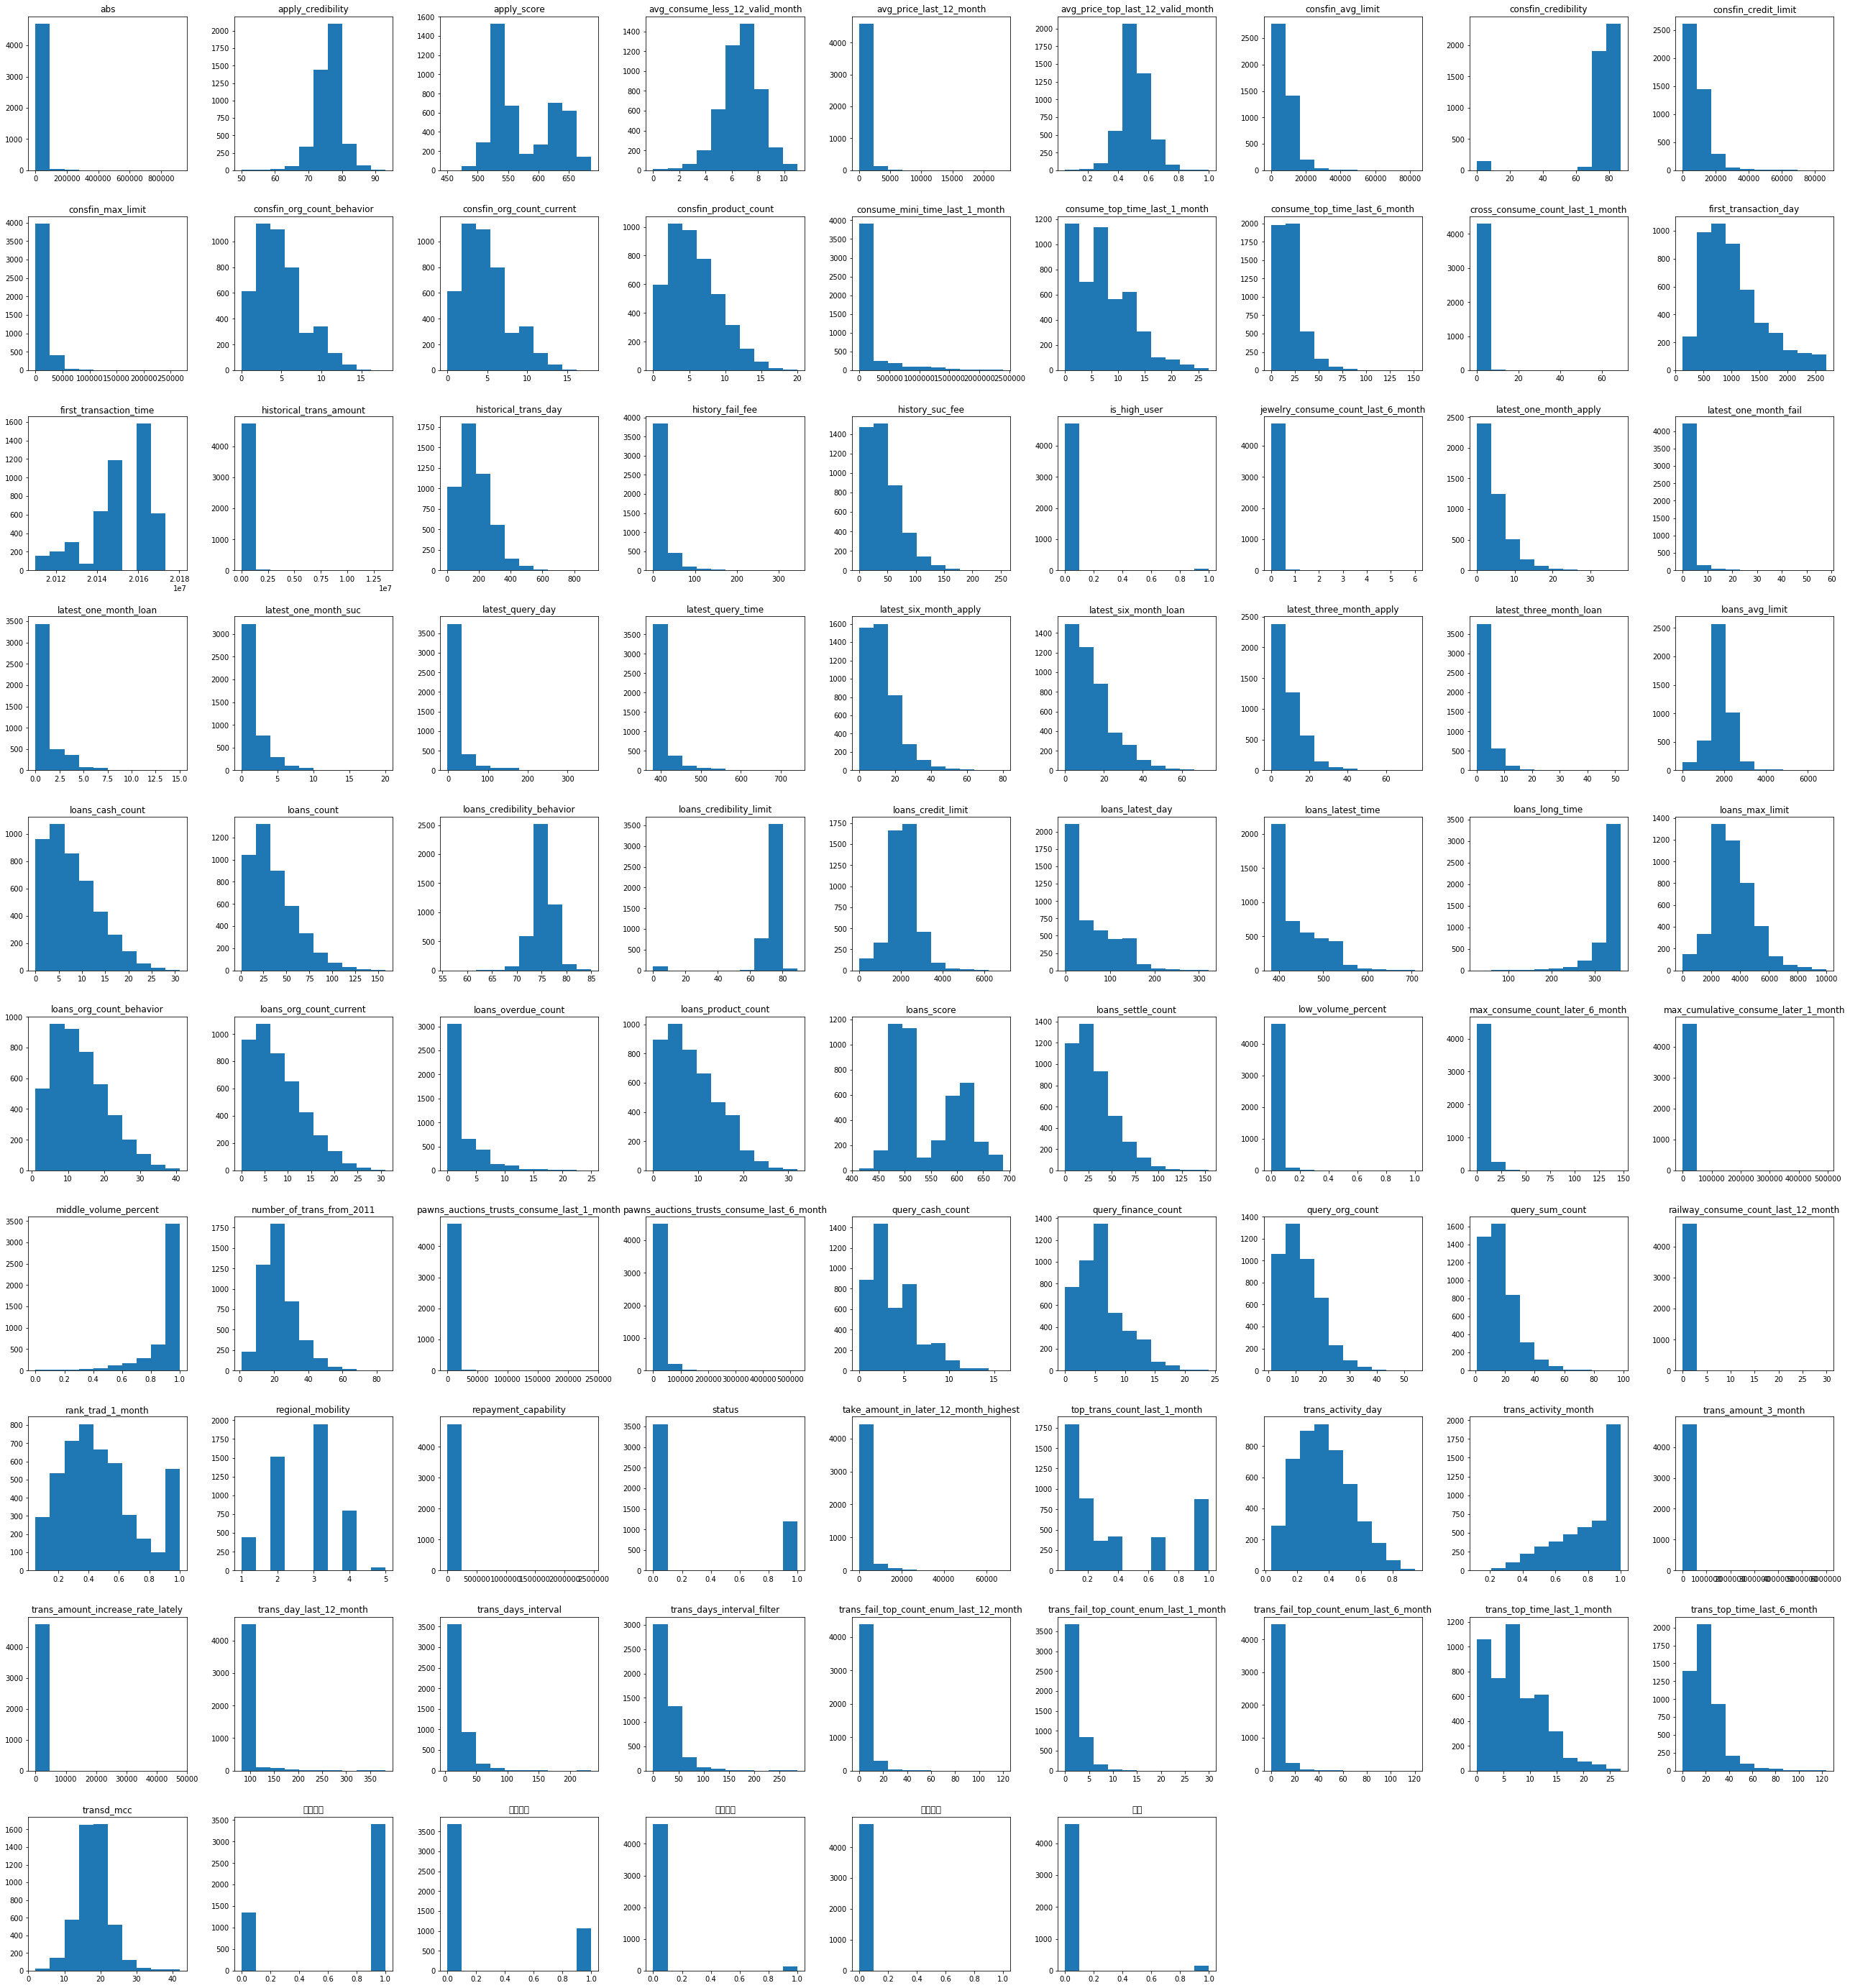

In [20]:
#查看数据分布, 偏态分布  不适合均值填充
data.hist(figsize=(45, 50), grid=False)
plt.show()

In [21]:
#用中值进行填充,由于特征太多后面还是建议删除弱相关特征,暂时先不操作,且感觉用中值填充也不太好
#并检查是否特征还含有null
for i in data.keys():
    data[i].fillna(data[i].median(), inplace=True)
data.isnull().sum().sort_values(ascending=False)

境外                                            0
consume_mini_time_last_1_month                0
trans_top_time_last_1_month                   0
trans_top_time_last_6_month                   0
consume_top_time_last_1_month                 0
consume_top_time_last_6_month                 0
cross_consume_count_last_1_month              0
trans_fail_top_count_enum_last_1_month        0
trans_fail_top_count_enum_last_6_month        0
trans_fail_top_count_enum_last_12_month       0
max_cumulative_consume_later_1_month          0
avg_price_last_12_month                       0
max_consume_count_later_6_month               0
railway_consume_count_last_12_month           0
pawns_auctions_trusts_consume_last_1_month    0
pawns_auctions_trusts_consume_last_6_month    0
jewelry_consume_count_last_6_month            0
status                                        0
first_transaction_day                         0
trans_day_last_12_month                       0
avg_price_top_last_12_valid_month       

In [22]:
y = data['status']
data.drop(['status'], axis=1, inplace=True)
x = data

In [23]:
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=666, stratify=np.array(y))

In [24]:
#这次是为了找feature_importance_ 所以先不上网格搜索,大致感受一下准确率  poly 还没用,随机森立不需要..
#树形模型不需要归一化
from sklearn.preprocessing import *
from sklearn.ensemble import *
std = StandardScaler()
std.fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

In [25]:
random_forest = RandomForestClassifier(n_estimators=250, max_depth=4, n_jobs=-1, oob_score=True, random_state=666, verbose=1)
random_forest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=True, random_state=666, verbose=1,
                       warm_start=False)

In [26]:
random_forest.oob_score_

0.7805831079050195

In [27]:
random_forest.score(x_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


0.7715487035739313

In [28]:
#观察一下 y的分布,  也就是瞎猜都是0也有75%的准确率. 然而上面准确率也有77%
#所以应该用recall 和precision F1 score
sum(y)/len(y)

0.2509465713083719

In [29]:
y_pred = random_forest.predict(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


In [30]:
from sklearn.metrics import *
F1 = f1_score(y_test, y_pred)
F1

0.2200956937799043

In [31]:
#根据贷款逾期 这个说法 选择 recall为标准最好, 而是recall水平相当低 ...非常弱的分类器
recall_score(y_test, y_pred)

0.12849162011173185

In [32]:
precision_score(y_test, y_pred)

0.7666666666666667

In [33]:
#结果不太行...弱分类器 需要改进
random_forest.feature_importances_

array([0.00206511, 0.00312688, 0.00164466, 0.00405441, 0.00210729,
       0.0056096 , 0.00273466, 0.00380326, 0.002759  , 0.00082229,
       0.00345418, 0.        , 0.00275215, 0.0053641 , 0.01130195,
       0.00663224, 0.0152209 , 0.0140189 , 0.00145263, 0.00331891,
       0.00575582, 0.00503007, 0.00287823, 0.01264084, 0.00216672,
       0.01147226, 0.00387565, 0.00028196, 0.12672781, 0.02766013,
       0.02578361, 0.0029626 , 0.02152745, 0.0009693 , 0.00014186,
       0.00517033, 0.00586236, 0.        , 0.00471691, 0.01700264,
       0.08140587, 0.00234689, 0.00223889, 0.00219708, 0.00188498,
       0.00207289, 0.00623677, 0.00320596, 0.00404163, 0.00361925,
       0.11033762, 0.00166584, 0.00547898, 0.00434088, 0.0764307 ,
       0.00327308, 0.00227629, 0.00223697, 0.00141472, 0.00570175,
       0.00525843, 0.00404782, 0.11886948, 0.0232411 , 0.09424407,
       0.00199004, 0.00411613, 0.0019837 , 0.00154463, 0.00256804,
       0.00264725, 0.00241305, 0.00421362, 0.00498049, 0.00107

In [34]:
#取>0.01的(自我感觉), 也就是前16个
sum(np.array(sorted(random_forest.feature_importances_)[::-1])>0.01)

16

In [35]:
index = random_forest.feature_importances_.argsort()[::-1][:16]
index

array([28, 62, 50, 64, 40, 54, 29, 30, 63, 32, 39, 16, 17, 23, 25, 14],
      dtype=int64)

In [36]:
#通过random_forest 应该留下的特征名字
random_forest_feature = x.columns[index]
random_forest_feature

Index(['trans_fail_top_count_enum_last_1_month', 'history_fail_fee',
       'loans_score', 'latest_one_month_fail', 'apply_score',
       'loans_overdue_count', 'trans_fail_top_count_enum_last_6_month',
       'trans_fail_top_count_enum_last_12_month', 'latest_one_month_suc',
       'max_cumulative_consume_later_1_month', 'trans_day_last_12_month',
       'rank_trad_1_month', 'trans_amount_3_month',
       'trans_top_time_last_1_month', 'consume_top_time_last_1_month',
       'historical_trans_amount'],
      dtype='object')

In [37]:
#留下16个特征
x_random_forest_feature = x[random_forest_feature]
x_random_forest_feature

,trans_fail_top_count_enum_last_1_month,history_fail_fee,loans_score,latest_one_month_fail,apply_score,loans_overdue_count,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,latest_one_month_suc,max_cumulative_consume_later_1_month,trans_day_last_12_month,rank_trad_1_month,trans_amount_3_month,trans_top_time_last_1_month,consume_top_time_last_1_month,historical_trans_amount
0,1.0,7.0,552.0,0.0,583.0,2.0,2.0,2.0,1.0,2170,85.0,0.40,34030,4.0,4.0,149050
1,0.0,4.0,635.0,1.0,653.0,0.0,3.0,3.0,2.0,2100,84.0,0.35,10590,13.0,13.0,302910
2,3.0,2.0,633.0,1.0,654.0,0.0,6.0,6.0,1.0,0,95.0,1.00,5710,0.0,0.0,11520
3,1.0,26.0,542.0,0.0,595.0,4.0,8.0,8.0,2.0,8140,82.0,0.15,91690,6.0,6.0,491130
4,3.0,25.0,479.0,0.0,541.0,6.0,3.0,3.0,0.0,1000,88.0,0.65,9770,0.0,0.0,61470
5,0.0,12.0,676.0,0.0,682.0,0.0,3.0,3.0,4.0,2560,82.0,0.20,78890,4.0,4.0,416670
6,0.0,6.0,612.0,2.0,626.0,0.0,1.0,1.0,1.0,0,98.0,1.00,3080,0.0,0.0,34140
7,1.0,10.0,511.0,0.0,549.0,1.0,1.0,4.0,0.0,1540,93.0,0.40,13930,6.0,6.0,144600
8,0.0,53.0,451.0,21.0,491.0,11.0,1.0,1.0,0.0,1750,83.0,0.35,21760,10.0,10.0,172290
9,0.0,3.0,589.0,0.0,619.0,0.0,2.0,5.0,0.0,500,95.0,0.75,6640,0.0,0.0,37250


In [38]:
#定义计算iv值的函数  借鉴
#这里的缺陷是没有对连续变量进行分区域判断, 把连续变量也当做是离散变量,使用了unique
#2019.5.15 今天更新对连续变量进行划分做IV值, 如果unique分类大于10类以上才进行划分
def calc_iv(df, feature, y, pr=False):
    """
    Set pr=True to enable printing of output.

    Output:
      * iv: float,
      * data: pandas.DataFrame
    """
    lst = []
    if len(list(df[feature].unique())) <= 10:
        for i in range(df[feature].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数
            val = list(df[feature].unique())[i]
            lst.append([feature,
                        val,  # Value
                        df[df[feature] == val].count()[feature],  # 值为val 的总个数
                        df[(df[feature] == val) & (y == 0)].count()[feature],  # val为0的总个数
                        df[(df[feature] == val) & (y == 1)].count()[feature]])  # val为1的总个数
    else:
        df['new_feature']  = pd.qcut(df[feature], 10, duplicates='drop')

        for i in range(df['new_feature'].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数
            val = list(df['new_feature'].unique())[i]
            lst.append([feature,
                        val,  # Value
                        df[df['new_feature'] == val].count()[feature],  # 值为val 的总个数
                        df[(df['new_feature'] == val) & (y == 0)].count()[feature],  # val为0的总个数
                        df[(df['new_feature'] == val) & (y == 1)].count()[feature]])  # val为1的总个数
        df.drop(['new_feature'], axis=1, inplace=True)
        
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    
    

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print("IV = ", data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data


In [39]:
#借鉴
column_headers = list(x.columns.values)


d=[]
for i in column_headers:
    IV_1, data_1 = calc_iv(x, i, y)
    d.append(IV_1)
#整理成Series类型并合并
column_headers=pd.Series(column_headers,name='feature')
d=pd.Series(d,name='iv_value')


iv_result=pd.concat([column_headers,d],axis=1)
iv_result.sort_values(by='iv_value',ascending=False)



d:\python\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning:

divide by zero encountered in log



,feature,iv_value
28,trans_fail_top_count_enum_last_1_month,0.568203
62,history_fail_fee,0.534952
50,loans_score,0.460287
40,apply_score,0.400157
54,loans_overdue_count,0.351439
29,trans_fail_top_count_enum_last_6_month,0.262398
30,trans_fail_top_count_enum_last_12_month,0.248360
64,latest_one_month_fail,0.241960
16,rank_trad_1_month,0.116803
63,latest_one_month_suc,0.114055


In [40]:
#通过iv值应该留下的特征

#在机器学习的二分类问题中，IV值（Information Value）主要用来对输入变量进行编码和预测能力评估。
#特征变量IV值的大小即表示该变量预测能力的强弱。IV 值的取值范围是[0, 正无穷)，如果当前分组中只包含响应客户或者未响应客户时，IV = 正无穷。 
#量化指标含义如下：< 0.02useless for prediction、0.02 to 0.1Weak predictor、0.1 to 0.3Medium predictor、
#0.3 to 0.5Strong predictor 、>0.5 Suspicious or too good to be true。
#留下36个特征
iv_feature = iv_result[iv_result['iv_value']>=0.02]['feature']
x_iv_feature = x[iv_feature]
x_iv_feature

,middle_volume_percent,trans_amount_increase_rate_lately,trans_days_interval_filter,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,top_trans_count_last_1_month,avg_price_last_12_month,...,latest_six_month_loan,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_latest_time,consfin_credit_limit,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,0.99,0.90,27.0,20130817.0,149050,151.0,0.40,34030,0.15,1020,...,13.0,7.0,1.0,0.0,399.0,1200.0,1200.0,1200.0,12.0,18.0
1,0.94,1.28,30.0,20160402.0,302910,224.0,0.35,10590,0.05,1210,...,8.0,4.0,2.0,1.0,383.0,15100.0,22800.0,9360.0,4.0,2.0
2,0.96,1.00,68.0,20170617.0,11520,31.0,1.00,5710,0.65,570,...,4.0,2.0,1.0,1.0,387.0,4200.0,4200.0,4200.0,2.0,6.0
3,0.96,0.13,14.0,20130516.0,491130,360.0,0.15,91690,0.05,1290,...,34.0,26.0,2.0,0.0,385.0,16300.0,30000.0,12180.0,2.0,4.0
4,0.99,0.46,66.0,20170312.0,61470,63.0,0.65,9770,1.00,1110,...,10.0,25.0,0.0,0.0,501.0,8300.0,8400.0,8250.0,22.0,120.0
5,0.98,7.59,8.0,20160920.0,416670,317.0,0.20,78890,0.05,1160,...,25.0,12.0,4.0,0.0,385.0,11200.0,20400.0,8130.0,3.0,4.0
6,0.98,23.67,54.0,20161112.0,34140,50.0,1.00,3080,1.00,1250,...,3.0,6.0,1.0,2.0,384.0,7600.0,16800.0,8900.0,1.0,3.0
7,0.98,0.25,20.0,20150512.0,144600,198.0,0.40,13930,0.10,920,...,11.0,10.0,0.0,0.0,418.0,7700.0,13800.0,7050.0,14.0,36.0
8,0.65,0.31,21.0,20150218.0,172290,253.0,0.35,21760,0.05,860,...,16.0,53.0,0.0,21.0,388.0,5500.0,19200.0,7987.0,24.0,7.0
9,0.99,0.80,36.0,20170105.0,37250,44.0,0.75,6640,1.00,1110,...,6.0,3.0,0.0,0.0,526.0,0.0,0.0,0.0,18.0,142.0


In [41]:
#先用random_forest 的特征值做预测
#逻辑回归,svm,决策树,随机森林,xgboost 使用recall作为评分标准  且暂时不添加poly项
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x_random_forest_feature,y,train_size=0.7,random_state=666, stratify=np.array(y))

from sklearn.preprocessing import *
from sklearn.ensemble import *
std = StandardScaler()
std.fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)



[LibLinear]

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.



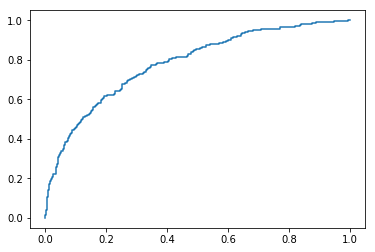

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997


In [42]:
random_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])

#逻辑回归
from sklearn.linear_model import *
logistic = LogisticRegression(n_jobs=-1, random_state=666, verbose=1)
logistic.fit(x_train_std, y_train)
y_pred = logistic.predict(x_test_std)
scores = logistic.predict_proba(x_test_std)[:, 1]

logistic_accuracy_score_random = accuracy_score(y_test, y_pred)
logistic_precision_score_random = precision_score(y_test, y_pred)
logistic_recall_score_random = recall_score(y_test, y_pred)
logistic_f1_score_random = f1_score(y_test, y_pred)
logistic_auc_score_random = roc_auc_score(y_test, scores)
logistic_fpr_score_random, logistic_tpr_score_random, logistic_thresholds_score_random = roc_curve(y_test, scores)

plt.plot(logistic_fpr_score_random, logistic_tpr_score_random, )
plt.show()

random_result.loc[0]=['logistic_random', logistic_accuracy_score_random, logistic_precision_score_random,
                  logistic_recall_score_random, logistic_f1_score_random, logistic_auc_score_random]
random_result

[LibSVM]

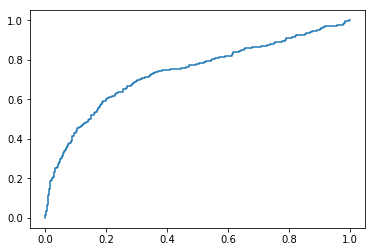

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766


In [43]:
#svm
from sklearn.svm import *
svc = SVC(random_state=666, verbose=1)
svc.fit(x_train_std, y_train)
y_pred = svc.predict(x_test_std)
scores = svc.decision_function(x_test_std)

svc_recall_score_random = recall_score(y_test, y_pred)

svc_accuracy_score_random = accuracy_score(y_test, y_pred)
svc_precision_score_random = precision_score(y_test, y_pred)
svc_recall_score_random = recall_score(y_test, y_pred)
svc_f1_score_random = f1_score(y_test, y_pred)
svc_auc_score_random = roc_auc_score(y_test, scores)

svc_fpr_score_random, svc_tpr_score_random, svc_thresholds_score_random = roc_curve(y_test, scores)

plt.plot(svc_fpr_score_random, svc_tpr_score_random, )
plt.show()

random_result.loc[1]=['svc_random', svc_accuracy_score_random, svc_precision_score_random,
                  svc_recall_score_random, svc_f1_score_random, svc_auc_score_random]
random_result

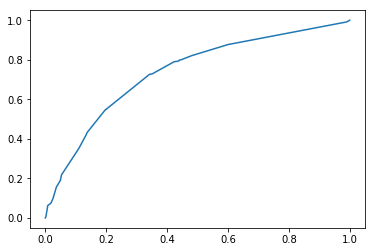

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766
2,dt_random,0.763840,0.577778,0.217877,0.316430,0.737271


In [44]:
#决策树
from sklearn.tree import *
dt = DecisionTreeClassifier(max_depth=5, random_state=666)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
scores = dt.predict_proba(x_test)[:, 1]

dt_recall_score_random = recall_score(y_test, y_pred)
dt_accuracy_score_random = accuracy_score(y_test, y_pred)
dt_precision_score_random = precision_score(y_test, y_pred)
dt_f1_score_random = f1_score(y_test, y_pred)
dt_auc_score_random = roc_auc_score(y_test, scores)

dt_fpr_score_random, dt_tpr_score_random, dt_thresholds_score_random = roc_curve(y_test, scores)

plt.plot(dt_fpr_score_random, dt_tpr_score_random, )
plt.show()

random_result.loc[2]=['dt_random', dt_accuracy_score_random, dt_precision_score_random,
                  dt_recall_score_random, dt_f1_score_random, dt_auc_score_random]
random_result


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


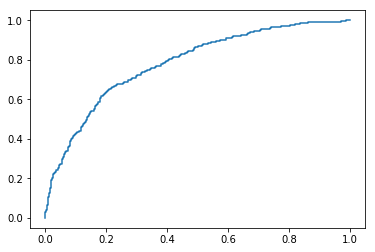

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766
2,dt_random,0.763840,0.577778,0.217877,0.316430,0.737271
3,rf_random,0.784863,0.742857,0.217877,0.336933,0.781679


In [45]:
#随机森林
from sklearn.ensemble import *
rf = RandomForestClassifier(n_estimators=250, max_depth=4, n_jobs=-1, oob_score=True, random_state=666, verbose=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
scores = rf.predict_proba(x_test)[:, 1]

rf_recall_score_random = recall_score(y_test, y_pred)
rf_accuracy_score_random = accuracy_score(y_test, y_pred)
rf_precision_score_random = precision_score(y_test, y_pred)
rf_f1_score_random = f1_score(y_test, y_pred)
rf_auc_score_random = roc_auc_score(y_test, scores)
rf_fpr_score_random, rf_tpr_score_random, rf_thresholds_score_random = roc_curve(y_test, scores)

plt.plot(rf_fpr_score_random, rf_tpr_score_random, )
plt.show()

random_result.loc[3]=['rf_random', rf_accuracy_score_random, rf_precision_score_random,
                  rf_recall_score_random, rf_f1_score_random, rf_auc_score_random]
random_result


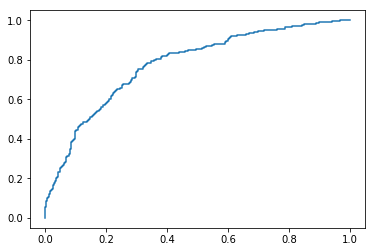

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766
2,dt_random,0.763840,0.577778,0.217877,0.316430,0.737271
3,rf_random,0.784863,0.742857,0.217877,0.336933,0.781679
4,xgb_random,0.771549,0.582474,0.315642,0.409420,0.776518


In [46]:
#xgboost
xgb = XGBClassifier(n_estimators=250, max_depth=4, random_state=666, n_jobs=-1)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
scores = xgb.predict_proba(x_test)[:, 1]

xgb_recall_score_random = recall_score(y_test, y_pred)
xgb_accuracy_score_random = accuracy_score(y_test, y_pred)
xgb_precision_score_random = precision_score(y_test, y_pred)
xgb_f1_score_random = f1_score(y_test, y_pred)
xgb_auc_score_random = roc_auc_score(y_test, scores)
xgb_fpr_score_random, xgb_tpr_score_random, xgb_thresholds_score_random = roc_curve(y_test, scores)

plt.plot(xgb_fpr_score_random, xgb_tpr_score_random, )
plt.show()

random_result.loc[4]=['xgb_random', xgb_accuracy_score_random, xgb_precision_score_random,
                  xgb_recall_score_random, xgb_f1_score_random, xgb_auc_score_random]
random_result





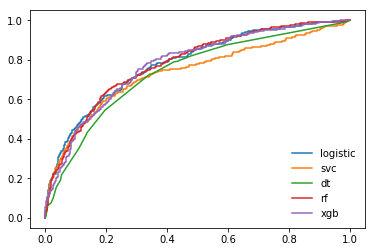

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766
2,dt_random,0.763840,0.577778,0.217877,0.316430,0.737271
3,rf_random,0.784863,0.742857,0.217877,0.336933,0.781679
4,xgb_random,0.771549,0.582474,0.315642,0.409420,0.776518


In [47]:

plt.plot(logistic_fpr_score_random, logistic_tpr_score_random, label='logistic')
plt.plot(svc_fpr_score_random, svc_tpr_score_random, label='svc')
plt.plot(dt_fpr_score_random, dt_tpr_score_random, label='dt')
plt.plot(rf_fpr_score_random, rf_tpr_score_random, label='rf')
plt.plot(xgb_fpr_score_random, xgb_tpr_score_random, label='xgb')
plt.legend(frameon=False)
plt.show()

(random_result)

In [48]:
#在使用IV值 的特征值做预测
#逻辑回归,svm,决策树,随机森林,xgboost 使用recall作为评分标准  且暂时不添加poly项
iv_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x_iv_feature,y,train_size=0.7,random_state=666, stratify=np.array(y))
iv_dict = {}
from sklearn.preprocessing import *
from sklearn.ensemble import *
std = StandardScaler()
std.fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

#逻辑回归
from sklearn.linear_model import *
logistic = LogisticRegression(n_jobs=-1, random_state=666, verbose=1)
logistic.fit(x_train_std, y_train)
y_pred = logistic.predict(x_test_std)
scores = logistic.predict_proba(x_test_std)[:, 1]

logistic_accuracy_score_iv = accuracy_score(y_test, y_pred)
logistic_precision_score_iv = precision_score(y_test, y_pred)
logistic_recall_score_iv = recall_score(y_test, y_pred)
logistic_f1_score_iv = f1_score(y_test, y_pred)
logistic_auc_score_iv = roc_auc_score(y_test, scores)
logistic_fpr_score_iv, logistic_tpr_score_iv, logistic_thresholds_score_iv = roc_curve(y_test, scores)


iv_result.loc[0]=['logistic_iv', logistic_accuracy_score_iv, logistic_precision_score_iv,
                  logistic_recall_score_iv, logistic_f1_score_iv, logistic_auc_score_iv]


iv_dict['logistic_recall'] = logistic_recall_score_iv

#svm
from sklearn.svm import *
svc = SVC(random_state=666, verbose=1)
svc.fit(x_train_std, y_train)
y_pred = svc.predict(x_test_std)
scores = svc.decision_function(x_test_std)

svc_accuracy_score_iv = accuracy_score(y_test, y_pred)
svc_precision_score_iv = precision_score(y_test, y_pred)
svc_recall_score_iv = recall_score(y_test, y_pred)
svc_f1_score_iv = f1_score(y_test, y_pred)
svc_auc_score_iv = roc_auc_score(y_test, scores)
svc_fpr_score_iv, svc_tpr_score_iv, svc_thresholds_score_iv = roc_curve(y_test, scores)


iv_result.loc[1]=['svc_iv', svc_accuracy_score_iv, svc_precision_score_iv,
                  svc_recall_score_iv, svc_f1_score_iv, svc_auc_score_iv]
iv_dict['svc_recall'] = svc_recall_score_iv

#决策树
from sklearn.tree import *
dt = DecisionTreeClassifier(max_depth=5, random_state=666)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
scores = dt.predict_proba(x_test)[:, 1]

dt_recall_score_iv = recall_score(y_test, y_pred)
dt_accuracy_score_iv = accuracy_score(y_test, y_pred)
dt_precision_score_iv = precision_score(y_test, y_pred)
dt_f1_score_iv = f1_score(y_test, y_pred)
dt_auc_score_iv = roc_auc_score(y_test, scores)
dt_fpr_score_iv, dt_tpr_score_iv, dt_thresholds_score_iv = roc_curve(y_test, scores)

iv_result.loc[2]=['dt_iv', dt_accuracy_score_iv, dt_precision_score_iv,
                  dt_recall_score_iv, dt_f1_score_iv, dt_auc_score_iv]

iv_dict['dt_recall'] = dt_recall_score_iv

#随机森林
from sklearn.ensemble import *
rf = RandomForestClassifier(n_estimators=250, max_depth=4, n_jobs=-1, oob_score=True, random_state=666, verbose=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
scores = rf.predict_proba(x_test)[:, 1]

rf_recall_score_iv = recall_score(y_test, y_pred)
rf_accuracy_score_iv = accuracy_score(y_test, y_pred)
rf_precision_score_iv = precision_score(y_test, y_pred)
rf_f1_score_iv = f1_score(y_test, y_pred)
rf_auc_score_iv = roc_auc_score(y_test, scores)
rf_fpr_score_iv, rf_tpr_score_iv, rf_thresholds_score_iv = roc_curve(y_test, scores)

iv_result.loc[3]=['rf_iv', rf_accuracy_score_iv, rf_precision_score_iv,
                  rf_recall_score_iv, rf_f1_score_iv, rf_auc_score_iv]


iv_dict['rf_recall'] = rf_recall_score_iv

#xgboost
xgb = XGBClassifier(n_estimators=250, max_depth=4, random_state=666, n_jobs=-1)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
scores = xgb.predict_proba(x_test)[:, 1]

xgb_recall_score_iv = recall_score(y_test, y_pred)
xgb_accuracy_score_iv = accuracy_score(y_test, y_pred)
xgb_precision_score_iv = precision_score(y_test, y_pred)
xgb_f1_score_iv = f1_score(y_test, y_pred)
xgb_auc_score_iv = roc_auc_score(y_test, scores)
xgb_fpr_score_iv, xgb_tpr_score_iv, xgb_thresholds_score_iv = roc_curve(y_test, scores)


iv_result.loc[4]=['xgb_iv', xgb_accuracy_score_iv, xgb_precision_score_iv,
                  xgb_recall_score_iv, xgb_f1_score_iv, xgb_auc_score_iv]

iv_dict['xgb_recall'] = xgb_recall_score_iv

iv_dict

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.



[LibLinear][LibSVM]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


{'logistic_recall': 0.3128491620111732,
 'svc_recall': 0.26256983240223464,
 'dt_recall': 0.21787709497206703,
 'rf_recall': 0.1871508379888268,
 'xgb_recall': 0.3575418994413408}

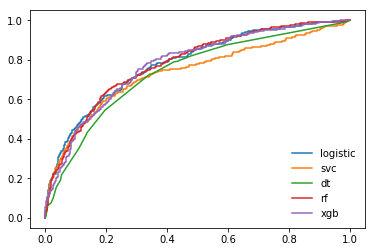

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_random,0.793973,0.695122,0.318436,0.436782,0.781997
1,svc_random,0.786966,0.717742,0.248603,0.369295,0.735766
2,dt_random,0.763840,0.577778,0.217877,0.316430,0.737271
3,rf_random,0.784863,0.742857,0.217877,0.336933,0.781679
4,xgb_random,0.771549,0.582474,0.315642,0.409420,0.776518


In [49]:
#还未调参 和 crossvalidation 和stacking
plt.plot(logistic_fpr_score_random, logistic_tpr_score_random, label='logistic')
plt.plot(svc_fpr_score_random, svc_tpr_score_random, label='svc')
plt.plot(dt_fpr_score_random, dt_tpr_score_random, label='dt')
plt.plot(rf_fpr_score_random, rf_tpr_score_random, label='rf')
plt.plot(xgb_fpr_score_random, xgb_tpr_score_random, label='xgb')
plt.legend(frameon=False)
plt.show()

(random_result)

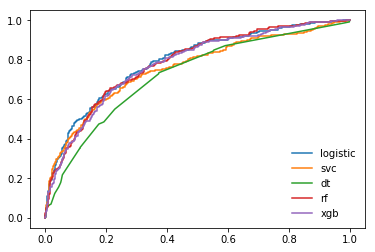

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_iv,0.790470,0.678788,0.312849,0.428298,0.791412
1,svc_iv,0.794674,0.764228,0.262570,0.390852,0.758820
2,dt_iv,0.761738,0.565217,0.217877,0.314516,0.723392
3,rf_iv,0.783462,0.788235,0.187151,0.302483,0.784945
4,xgb_iv,0.782761,0.615385,0.357542,0.452297,0.778520


In [50]:
plt.plot(logistic_fpr_score_iv, logistic_tpr_score_iv, label='logistic')
plt.plot(svc_fpr_score_iv, svc_tpr_score_iv, label='svc')
plt.plot(dt_fpr_score_iv, dt_tpr_score_iv, label='dt')
plt.plot(rf_fpr_score_iv, rf_tpr_score_iv, label='rf')
plt.plot(xgb_fpr_score_iv, xgb_tpr_score_iv, label='xgb')
plt.legend(frameon=False)
plt.show()

iv_result

In [51]:
#选用IV特征值作为调参数据
#在使用IV值 的特征值做预测
#逻辑回归,svm,决策树,随机森林,xgboost 使用recall作为评分标准  且暂时不添加poly项
iv_gridsearch_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x_iv_feature,y,train_size=0.7,random_state=666, stratify=np.array(y))
from sklearn.preprocessing import *
from sklearn.ensemble import *
std = StandardScaler()
std.fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

#逻辑回归
from sklearn.linear_model import *
logistic = LogisticRegression(n_jobs=-1, random_state=666, verbose=1)
lr_params = {'penalty':['l1', 'l2'],
            'C':[0.0001, 0.001, 0.01, 0.1, 1.0 , 5,10]}
lr_gridsearch = GridSearchCV(logistic, param_grid=lr_params, 
                             scoring='recall', n_jobs=-1, 
                             verbose=1, cv=5)
lr_gridsearch.fit(x_train_std, y_train)
y_pred = lr_gridsearch.best_estimator_ .predict(x_test_std)
scores = lr_gridsearch.best_estimator_ .predict_proba(x_test_std)[:, 1]

logistic_accuracy_score_iv = accuracy_score(y_test, y_pred)
logistic_precision_score_iv = precision_score(y_test, y_pred)
logistic_recall_score_iv = recall_score(y_test, y_pred)
logistic_f1_score_iv = f1_score(y_test, y_pred)
logistic_auc_score_iv = roc_auc_score(y_test, scores)
logistic_fpr_score_iv, logistic_tpr_score_iv, logistic_thresholds_score_iv = roc_curve(y_test, scores)


iv_gridsearch_result.loc[0]=['logistic_iv', logistic_accuracy_score_iv, logistic_precision_score_iv,
                  logistic_recall_score_iv, logistic_f1_score_iv, logistic_auc_score_iv]



#svm
from sklearn.svm import *
svc = SVC(random_state=666, verbose=1)
svc_params = {'kernel':['rbf', 'poly', 'linear', 'sigmoid'],
            'C':[0.0001, 0.001, 0.01, 0.1, 1.0 , 5, 10, 100],
             'degree':[2, 3]
             }
svc_gridsearch = GridSearchCV(svc, param_grid=svc_params, 
                             scoring='recall', n_jobs=-1, 
                             verbose=1, cv=5)
svc_gridsearch.fit(x_train_std, y_train)

y_pred = svc_gridsearch.best_estimator_.predict(x_test_std)
scores = svc_gridsearch.best_estimator_.decision_function(x_test_std)

svc_accuracy_score_iv = accuracy_score(y_test, y_pred)
svc_precision_score_iv = precision_score(y_test, y_pred)
svc_recall_score_iv = recall_score(y_test, y_pred)
svc_f1_score_iv = f1_score(y_test, y_pred)
svc_auc_score_iv = roc_auc_score(y_test, scores)
svc_fpr_score_iv, svc_tpr_score_iv, svc_thresholds_score_iv = roc_curve(y_test, scores)


iv_gridsearch_result.loc[1]=['svc_iv', svc_accuracy_score_iv, svc_precision_score_iv,
                  svc_recall_score_iv, svc_f1_score_iv, svc_auc_score_iv]


#决策树
from sklearn.tree import *
dt = DecisionTreeClassifier(max_depth=5, random_state=666)
dt_params = {'max_depth':[2,3,4,5,6],
            'criterion':['gini', 'entropy'],
             'min_samples_split':[2, 3,4,5,6]
             }
dt_gridsearch = GridSearchCV(dt, param_grid=dt_params, 
                             scoring='recall', n_jobs=-1, 
                             verbose=1, cv=5)
dt_gridsearch.fit(x_train, y_train)

y_pred = dt_gridsearch.best_estimator_.predict(x_test)
scores = dt_gridsearch.best_estimator_.predict_proba(x_test)[:, 1]


dt_recall_score_iv = recall_score(y_test, y_pred)
dt_accuracy_score_iv = accuracy_score(y_test, y_pred)
dt_precision_score_iv = precision_score(y_test, y_pred)
dt_f1_score_iv = f1_score(y_test, y_pred)
dt_auc_score_iv = roc_auc_score(y_test, scores)
dt_fpr_score_iv, dt_tpr_score_iv, dt_thresholds_score_iv = roc_curve(y_test, scores)

iv_gridsearch_result.loc[2]=['dt_iv', dt_accuracy_score_iv, dt_precision_score_iv,
                  dt_recall_score_iv, dt_f1_score_iv, dt_auc_score_iv]



#随机森林
from sklearn.ensemble import *
rf = RandomForestClassifier(n_estimators=250, max_depth=4, n_jobs=-1, oob_score=True, random_state=666, verbose=1)
rf_params = {'max_depth':[3,4,5,6],
             'n_estimators':[100, 150, 200, 250, 300],
            'criterion':['gini', 'entropy'],
             'min_samples_split':[3,4,5,6]
             }
rf_gridsearch = GridSearchCV(rf, param_grid=rf_params, 
                             scoring='recall', n_jobs=-1, 
                             verbose=1, cv=5)
rf_gridsearch.fit(x_train, y_train)

y_pred = rf_gridsearch.best_estimator_.predict(x_test)
scores = rf_gridsearch.best_estimator_.predict_proba(x_test)[:, 1]


rf_recall_score_iv = recall_score(y_test, y_pred)
rf_accuracy_score_iv = accuracy_score(y_test, y_pred)
rf_precision_score_iv = precision_score(y_test, y_pred)
rf_f1_score_iv = f1_score(y_test, y_pred)
rf_auc_score_iv = roc_auc_score(y_test, scores)
rf_fpr_score_iv, rf_tpr_score_iv, rf_thresholds_score_iv = roc_curve(y_test, scores)

iv_gridsearch_result.loc[3]=['rf_iv', rf_accuracy_score_iv, rf_precision_score_iv,
                  rf_recall_score_iv, rf_f1_score_iv, rf_auc_score_iv]




#xgboost
xgb = XGBClassifier(n_estimators=250, max_depth=4, random_state=666, n_jobs=-1)
xgb_params = {'max_depth':[3,4,5,6],
             'n_estimators':[100, 150, 200, 250, 300],
              'min_child_weight':[1,2,3,4,5,6],
             'learning_rate':[  0.01, 0.1, 1 ]
             }
xgb_gridsearch = GridSearchCV(xgb, param_grid=xgb_params, 
                             scoring='recall', n_jobs=-1, 
                             verbose=1, cv=5)
xgb_gridsearch.fit(x_train, y_train)
y_pred = xgb_gridsearch.best_estimator_.predict(x_test)
scores = xgb_gridsearch.best_estimator_.predict_proba(x_test)[:, 1]

xgb_recall_score_iv = recall_score(y_test, y_pred)
xgb_accuracy_score_iv = accuracy_score(y_test, y_pred)
xgb_precision_score_iv = precision_score(y_test, y_pred)
xgb_f1_score_iv = f1_score(y_test, y_pred)
xgb_auc_score_iv = roc_auc_score(y_test, scores)
xgb_fpr_score_iv, xgb_tpr_score_iv, xgb_thresholds_score_iv = roc_curve(y_test, scores)


iv_gridsearch_result.loc[4]=['xgb_iv', xgb_accuracy_score_iv, xgb_precision_score_iv,
                  xgb_recall_score_iv, xgb_f1_score_iv, xgb_auc_score_iv]

iv_gridsearch_result

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.5s finished
C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.0min finished


[LibSVM]Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBack

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  7.8min finished


,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_iv,0.765242,0.533333,0.513966,0.523471,0.765930
1,svc_iv,0.728802,0.457971,0.441341,0.449502,0.692777
2,dt_iv,0.754730,0.519048,0.304469,0.383803,0.700324
3,rf_iv,0.789769,0.733871,0.254190,0.377593,0.791961
4,xgb_iv,0.741416,0.480702,0.382682,0.426128,0.704687


In [52]:
from sklearn.pipeline import Pipeline
from mlxtend.classifier import StackingClassifier
x_train,x_test,y_train,y_test=train_test_split(x_iv_feature,y,train_size=0.7,random_state=666, stratify=np.array(y))

lr_best = Pipeline([('standardscaler', StandardScaler()),
                    ('lr', lr_gridsearch.best_estimator_ )   
])
svc_best = Pipeline([('standardscaler', StandardScaler()),
                    ('svc', svc_gridsearch.best_estimator_ )   
])
dt_bset = dt_gridsearch.best_estimator_
rf_best = rf_gridsearch.best_estimator_
xgb_best = xgb_gridsearch.best_estimator_


# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf_without_prob = StackingClassifier(classifiers=[xgb_best, svc_best, dt_bset,
                                       rf_best,  lr_best],
                            meta_classifier=lr_gridsearch.best_estimator_
                          )

grid_without_prob = GridSearchCV(sclf_without_prob,
                                param_grid={'meta_classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0 , 5,10],
                                           'meta_classifier__penalty':['l1', 'l2']},
                                cv=5, n_jobs=-1,  scoring='recall',
                             verbose=1,)
grid_without_prob.fit(x_train, y_train)

y_pred = grid_without_prob.best_estimator_.predict(x_test)
scores = grid_without_prob.best_estimator_.predict_proba(x_test)[:, 1]

grid_without_prob_recall_score_iv = recall_score(y_test, y_pred)
grid_without_prob_accuracy_score_iv = accuracy_score(y_test, y_pred)
grid_without_prob_precision_score_iv = precision_score(y_test, y_pred)
grid_without_prob_f1_score_iv = f1_score(y_test, y_pred)
grid_without_prob_auc_score_iv = roc_auc_score(y_test, scores)
grid_without_prob_fpr_score_iv, grid_without_prob_tpr_score_iv, grid_without_prob_thresholds_score_iv = roc_curve(y_test, scores)


iv_gridsearch_result.loc[5]=['grid_without_prob_iv', grid_without_prob_accuracy_score_iv, grid_without_prob_precision_score_iv,
                  grid_without_prob_recall_score_iv, grid_without_prob_f1_score_iv, grid_without_prob_auc_score_iv]

iv_gridsearch_result


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   21.5s finished


[LibSVM]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[LibLinear]

[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[LibLinear]

[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_iv,0.765242,0.533333,0.513966,0.523471,0.765930
1,svc_iv,0.728802,0.457971,0.441341,0.449502,0.692777
2,dt_iv,0.754730,0.519048,0.304469,0.383803,0.700324
3,rf_iv,0.789769,0.733871,0.254190,0.377593,0.791961
4,xgb_iv,0.741416,0.480702,0.382682,0.426128,0.704687
5,grid_without_prob_iv,0.741416,0.480702,0.382682,0.426128,0.622117


In [53]:
svc_gridsearch.best_estimator_.probability=True
svc_gridsearch.best_estimator_

from sklearn.pipeline import Pipeline
from mlxtend.classifier import StackingClassifier
x_train,x_test,y_train,y_test=train_test_split(x_iv_feature,y,train_size=0.7,random_state=666, stratify=np.array(y))

lr_best = Pipeline([('standardscaler', StandardScaler()),
                    ('lr', lr_gridsearch.best_estimator_ )   
])
svc_best = Pipeline([('standardscaler', StandardScaler()),
                    ('svc', svc_gridsearch.best_estimator_ )   
])
dt_bset = dt_gridsearch.best_estimator_
rf_best = rf_gridsearch.best_estimator_
xgb_best = xgb_gridsearch.best_estimator_


# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf_with_prob = StackingClassifier(classifiers=[xgb_best, svc_best, dt_bset,
                                       rf_best,  lr_best],
                            meta_classifier=lr_gridsearch.best_estimator_,
                                       use_probas=True,
                          )

grid_with_prob = GridSearchCV(sclf_without_prob,
                                param_grid={'meta_classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0 , 5,10],
                                           'meta_classifier__penalty':['l1', 'l2']},
                                cv=5, n_jobs=-1,  scoring='recall',
                             verbose=1,)
grid_with_prob.fit(x_train, y_train)

y_pred = grid_with_prob.best_estimator_.predict(x_test)
scores = grid_with_prob.best_estimator_.predict_proba(x_test)[:, 1]

grid_with_prob_recall_score_iv = recall_score(y_test, y_pred)
grid_with_prob_accuracy_score_iv = accuracy_score(y_test, y_pred)
grid_with_prob_precision_score_iv = precision_score(y_test, y_pred)
grid_with_prob_f1_score_iv = f1_score(y_test, y_pred)
grid_with_prob_auc_score_iv = roc_auc_score(y_test, scores)
grid_with_prob_fpr_score_iv, grid_with_prob_tpr_score_iv, grid_with_prob_thresholds_score_iv = roc_curve(y_test, scores)


iv_gridsearch_result.loc[6]=['grid_with_prob_iv', grid_with_prob_accuracy_score_iv, grid_with_prob_precision_score_iv,
                  grid_with_prob_recall_score_iv, grid_with_prob_f1_score_iv, grid_with_prob_auc_score_iv]

iv_gridsearch_result

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   26.6s finished


[LibSVM]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.0s finished
C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[LibLinear]

[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\马里基\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


[LibLinear]

[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.0s finished


,model,accuracy,precision,recall,f1_score,roc_auc_score
0,logistic_iv,0.765242,0.533333,0.513966,0.523471,0.765930
1,svc_iv,0.728802,0.457971,0.441341,0.449502,0.692777
2,dt_iv,0.754730,0.519048,0.304469,0.383803,0.700324
3,rf_iv,0.789769,0.733871,0.254190,0.377593,0.791961
4,xgb_iv,0.741416,0.480702,0.382682,0.426128,0.704687
5,grid_without_prob_iv,0.741416,0.480702,0.382682,0.426128,0.622117
6,grid_with_prob_iv,0.741416,0.480702,0.382682,0.426128,0.622117
